In [1]:
import boto3
import re
import sagemaker

role = sagemaker.get_execution_role()
sess = sagemaker.Session()
#session'a ait bir bucket ve bir prefix belirliyoruz
#aws'de bucket'lara ulaşmak için path'leri hep s3://bucket/prefix formatında girmek gerekiyor
bucket = sess.default_bucket()
prefix = 'xgb-churn'

In [2]:
# kendi bucket'ınızı oluşturmak isterseniz komutlar aşağıda
# bucket isimleri unique olmalı
#s3 = boto3.resource("s3")
#!aws s3 mb s3://demo-bucket-xgb-churn

In [3]:
#s3'e bir dosya eklemek isterseniz komut aşağıdaki gibi
#aws s3 cp test.txt s3://demo-bucket-cdl/

### Paketler ve eğitim verileri

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker
from sagemaker.predictor import csv_serializer

In [5]:
!wget http://dataminingconsultant.com/DKD2e_data_sets.zip
!unzip -o DKD2e_data_sets.zip

--2020-10-10 13:40:02--  http://dataminingconsultant.com/DKD2e_data_sets.zip
Resolving dataminingconsultant.com (dataminingconsultant.com)... 160.153.91.162
Connecting to dataminingconsultant.com (dataminingconsultant.com)|160.153.91.162|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1003616 (980K) [application/zip]
Saving to: ‘DKD2e_data_sets.zip.4’

DKD2e_data_sets.zip 100%[===================>] 980.09K  1.36MB/s    in 0.7s    

2020-10-10 13:40:03 (1.36 MB/s) - ‘DKD2e_data_sets.zip.4’ saved [1003616/1003616]

Archive:  DKD2e_data_sets.zip
 extracting: Data sets/adult.zip     
  inflating: Data sets/cars.txt      
  inflating: Data sets/cars2.txt     
  inflating: Data sets/cereals.CSV   
  inflating: Data sets/churn.txt     
  inflating: Data sets/ClassifyRisk  
  inflating: Data sets/ClassifyRisk - Missing.txt  
 extracting: Data sets/DKD2e data sets.zip  
  inflating: Data sets/nn1.txt       


In [6]:
churn = pd.read_csv('./Data sets/churn.txt')
churn.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


### Öznitelikler

- State: Eyaletler (iki harfli kodlar halinde)
- Account Length: Müşteri hesabının kaç gündür aktif olduğu
- Area Code: Üç haneli alan kodu
- Phone: Telefon numarası
- Int’l Plan: Müşterinin uluslararası planının olup olmadığı
- VMail Plan: Müşterinin sesli mesaj kullanıp kullanmadığı (yes/no)
- VMail Message: Müşterinin her ay ortalama kaç tane sesli mesaj aldığı
- Day Mins: Müşterinin her gün gün içinde averaj kaç dakika konuştuğu
- Day Calls: Müşterinin her gün gün içinde kaç kez arama yaptığı
- Day Charge: Müşterinin gün içindeki konuşmalarına ödediği miktar
- Eve Mins, Eve Calls, Eve Charge: Müşterinin akşam içinde kaç dakika konuştuğu, kaç kez arama yaptığı, ödediği miktar
- Night Mins, Night Calls, Night Charge: Müşterinin gece içinde kaç dakika konuştuğu, kaç kez arama yaptığı, ödediği miktar
- Intl Mins, Intl Calls, Intl Charge: Müşterinin uluslararası planda kaç dakika konuştuğu, kaç kez arama yaptığı, ödediği miktar
- CustServ Calls: Müşterinin müşteri hizmetlerini arama sayısı
- Churn?: Müşterinin hizmeti bırakıp bırakmadığı (true/false)

## Keşifsel Veri Analizi

Veri setinde dengesizlik var mı?

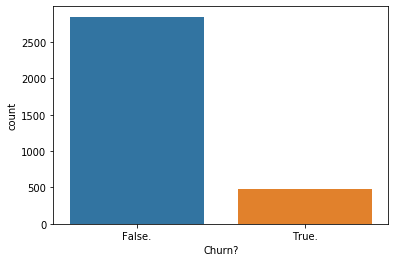

In [7]:
import seaborn as sns
sns.countplot(x="Churn?", data=churn)

Numerik özniteliklerin dağılımı, alan kodu (numerik gözükse de kategorik bir değişken), vmail message kolonları dışında dağılımlar normal gözüküyor.

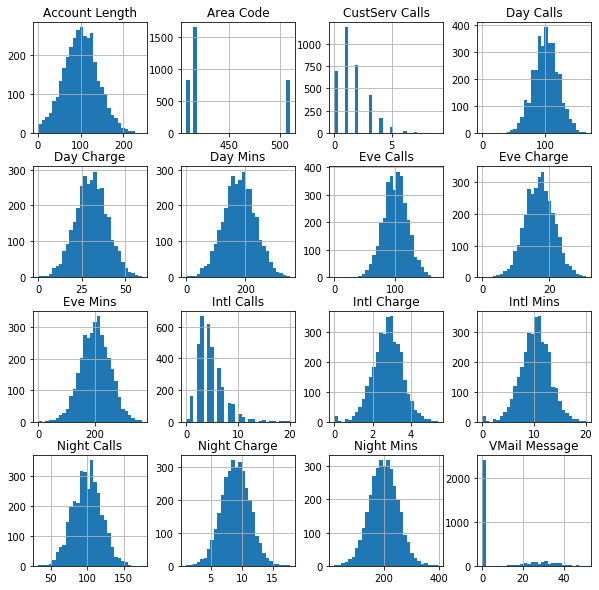

In [8]:
%matplotlib inline
hist = churn.hist(bins=30, figsize=(10, 10))

Churn yapanları kategorik verilerde gözlemleyebiliyor muyuz?
1. Her eyalete aşağı yukarı eşit dağılıyorlar.
2. Uluslararası görüşme yapma ihtimalleri çok yüksek.
3. Sesli mesaj planları yok. 
4. Müşteri hizmetleriyle daha fazla görüşüyorlar (sorun yaşadıkları için çok normal)

In [9]:
for column in churn.select_dtypes(include=['object']).columns:
    if column != 'Churn?':
        display(pd.crosstab(index=churn[column], columns=churn['Churn?'], normalize='columns'))

Churn?,False.,True.
State,,
AK,0.017193,0.006211
AL,0.025263,0.016563
AR,0.015439,0.022774
AZ,0.021053,0.008282
CA,0.008772,0.018634
CO,0.020000,0.018634
CT,0.021754,0.024845
DC,0.017193,0.010352
DE,0.018246,0.018634


Churn?,False.,True.
Phone,,
327-1058,0.000351,0.00000
327-1319,0.000351,0.00000
327-3053,0.000351,0.00000
327-3587,0.000000,0.00207
327-3850,0.000351,0.00000
...,...,...
422-7728,0.000351,0.00000
422-8268,0.000351,0.00000
422-8333,0.000351,0.00000


Churn?,False.,True.
Int'l Plan,,
no,0.934737,0.716356
yes,0.065263,0.283644


Churn?,False.,True.
VMail Plan,,
no,0.704561,0.834369
yes,0.295439,0.165631


## Korelasyon
İnsanların günlük konuşma sayılarına göre ödemeleri ve kaç dakika konuştukları arasında ilişki var, bunları veriden atmak gerek. Bunu uluslararası, akşam ve gece konuşmaları için de yapacağız.

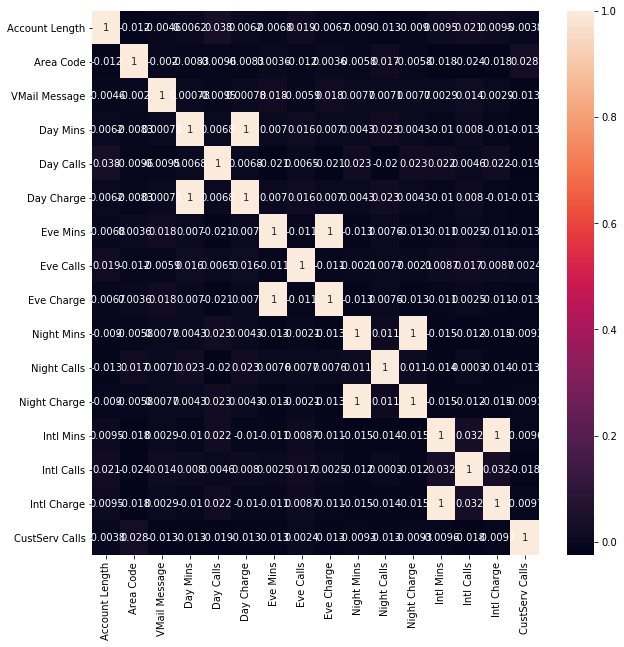

In [10]:
corr_churn = churn.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_churn, annot=True, ax=ax)

## Veri Önişleme

In [11]:
churn.drop(["Day Calls", "Day Charge", "Eve Calls", "Eve Charge",
            "Night Calls", "Night Charge","Intl Calls", "Intl Charge", 
            "Area Code", "Phone"], axis=1, inplace=True)
churn.head()

,State,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Eve Mins,Night Mins,Intl Mins,CustServ Calls,Churn?
0,KS,128,no,yes,25,265.1,197.4,244.7,10.0,1,False.
1,OH,107,no,yes,26,161.6,195.5,254.4,13.7,1,False.
2,NJ,137,no,no,0,243.4,121.2,162.6,12.2,0,False.
3,OH,84,yes,no,0,299.4,61.9,196.9,6.6,2,False.
4,OK,75,yes,no,0,166.7,148.3,186.9,10.1,3,False.


Heatmap'e tekrar bakalım

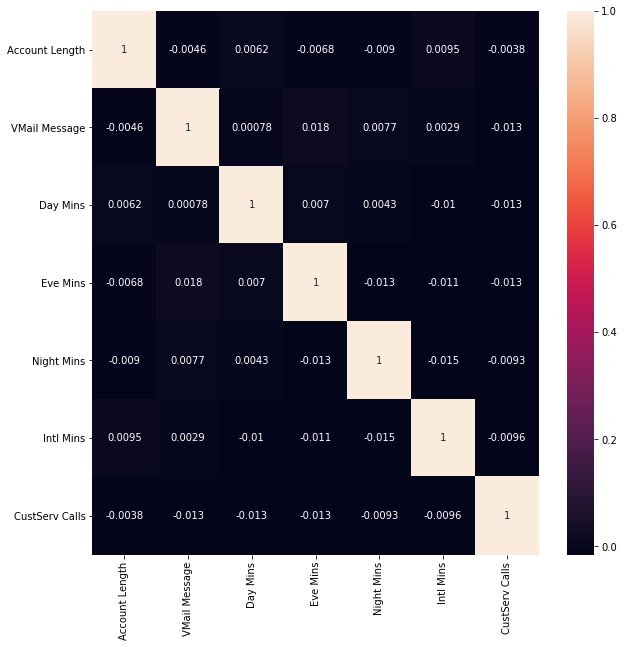

In [12]:
corr_churn = churn.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_churn, annot=True, ax=ax)

### Kategorik Veriler için One Hot Encoding

.get_dummies'e dataframe'i paslayarak encode edebiliriz. Bunun dışında encode ederken churn iki ayrı değere sahip olduğu için churn'ün olduğunu (True) alıp diğerini atmamız yeterli.
Burada dikkat edilmesi gereken başka bir şey AWS'de eğitim yaparken tahmin edeceğimiz kolon en solda olmalı. 

In [13]:
model_data = pd.get_dummies(churn)
model_data = pd.concat([model_data['Churn?_True.'], model_data.drop(['Churn?_False.', 'Churn?_True.'], axis=1)], axis=1)

In [14]:
model_data.head()

,Churn?_True.,Account Length,VMail Message,Day Mins,Eve Mins,Night Mins,Intl Mins,CustServ Calls,State_AK,State_AL,...,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Int'l Plan_no,Int'l Plan_yes,VMail Plan_no,VMail Plan_yes
0,0,128,25,265.1,197.4,244.7,10.0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
1,0,107,26,161.6,195.5,254.4,13.7,1,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,137,0,243.4,121.2,162.6,12.2,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,0,84,0,299.4,61.9,196.9,6.6,2,0,0,...,0,0,0,0,0,0,0,1,1,0
4,0,75,0,166.7,148.3,186.9,10.1,3,0,0,...,0,0,0,0,0,0,0,1,1,0


AWS Sagemaker XGBoost CSV ya da LibSVM formatıyla alıyor veriyi. Veriyi böldükten sonra CSV'ye çevirip S3'te saklayacağız.

In [15]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

## Eğitim ve Doğrulama Verisini S3'e Yükleme

In [16]:
boto3.Session().resource('s3').Bucket(name = "demo-bucket-xgb-churn").Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(name = "demo-bucket-xgb-churn").Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

### Opsiyonel: S3 bucket'ının içeriğini görmeniz için

Bu arada S3 bucket'ının içeriğiyle oynamanız için AWS komutlarını içeren faydalı bulduğum bir blog: http://carolynlangen.com/2017/11/22/interacting-with-aws-s3-using-python-in-a-jupyter-notebook/

In [20]:
#for bucket in s3.buckets.all():
#    for obj in bucket.objects.all():
#        print(os.path.join(obj.bucket_name, obj.key))

### XGBoost'un AWS'deki imajını alıp container oluşturuyoruz

In [21]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


Model eğitirken sagemaker'ın s3'teki veriyi kolayca alması için s3 input'u oluşturuyoruz.

In [22]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


### Model Eğitme

In [23]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-10-10 13:41:38 Starting - Starting the training job...
2020-10-10 13:41:39 Starting - Launching requested ML instances...
2020-10-10 13:42:36 Starting - Preparing the instances for training......
2020-10-10 13:43:25 Downloading - Downloading input data...
2020-10-10 13:44:05 Training - Training image download completed. Training in progress.
2020-10-10 13:44:05 Uploading - Uploading generated training modelArguments: train
[2020-10-10:13:44:00:INFO] Running standalone xgboost training.
[2020-10-10:13:44:00:INFO] File size need to be processed in the node: 0.72mb. Available memory size in the node: 8499.95mb
[2020-10-10:13:44:00:INFO] Determined delimiter of CSV input is ','
[13:44:00] S3DistributionType set as FullyReplicated
[13:44:00] 4666x62 matrix with 289292 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-10-10:13:44:00:INFO] Determined delimiter of CSV input is ','
[13:44:00] S3DistributionType set as FullyReplicated
[13:44:00] 666x62

sagemaker estimator'ın .deploy() metodu üretime hazır bir model oluşturur, sagemaker hosting endpoint'ini ayarlar ve endpoint'i başlatır.

In [24]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!

Tahminde alınacak verileri csv olarak geçirmek için serializer kullanıyoruz.

In [25]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

### Tahminde bulunma

In [29]:
def predict(data, rows=500): 
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1)) 
    #test verisetini batch'lere ayırdık
    predictions = ''
    for array in split_array: 
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])
         #predictor'la tahminlerde bulunup predictions listesine yazdik

    return np.fromstring(predictions[1:], sep=',')
    #csv'yi array haline getirdik

predictions = predict(test_data.to_numpy()[:, 1:]) 

Confusion Matrix
- Churn olarak tahmin edilip gerçekten churn çıkanların sayısı (true positive) 32
- Churn olan ama churn olarak tahmin edilmeyenler (false negative) önemli, bunların da sayısı 16

In [30]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,281,5
1,16,32
